In [3]:
# simple hmm mfcc cross-validation baseline

import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
import utils
print(sys.path)

['/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev', '/Users/david/Documents/mastersCode/ubm/final/models', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [5]:
import pandas as pd
import importlib
from whale.setup import get_data, constants, annotations
importlib.reload(get_data)
importlib.reload(annotations)
importlib.reload(constants)
from python_speech_features import mfcc, delta
import numpy as np
from spafe.utils import vis
import matplotlib.pyplot as plt
import IPython
from scipy.io import wavfile
import final.cross_validation

In [6]:
get_data_whale = get_data.GetDataBase(
    location_of_wav_file=constants.HUMPBACK_WAV_A,
    location_of_annotations=constants.HUMPBACK_LABEL_A,
    annotations=annotations.AnnotationsAudacity(),
    window_length=0.025, frame_step=0.01, samples=False)

In [7]:
get_data_noise = get_data.GetDataBase(
    location_of_wav_file=constants.HUMPBACK_WAV_A,
    location_of_annotations=constants.HUMPBACK_LABEL_A_NOISE,
    annotations=annotations.AnnotationsAudacity(),
    window_length=0.025, frame_step=0.01, samples=False)

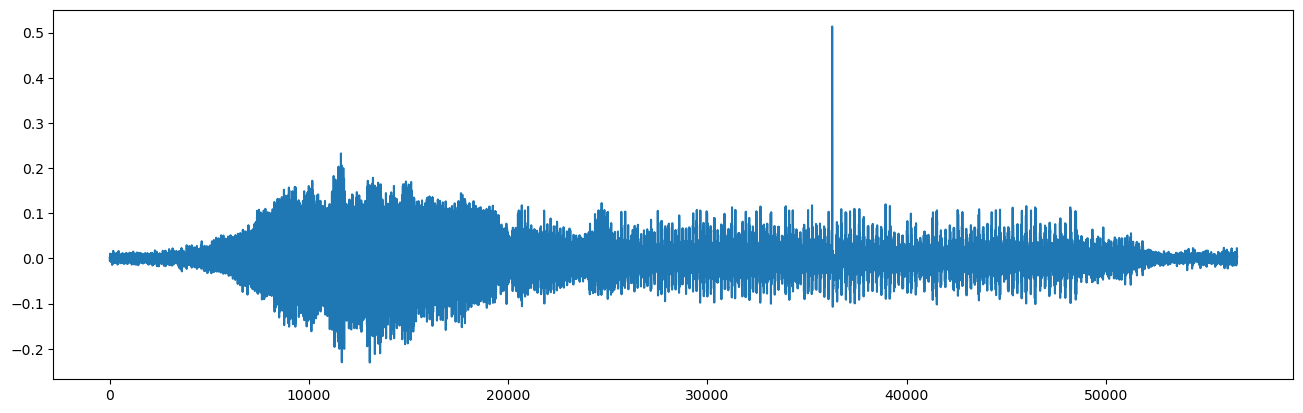

In [8]:
# view whale
audio = get_data_whale.audio
label = get_data_whale.annotations.annotations[5]
plt.plot(audio[label.start:label.end])

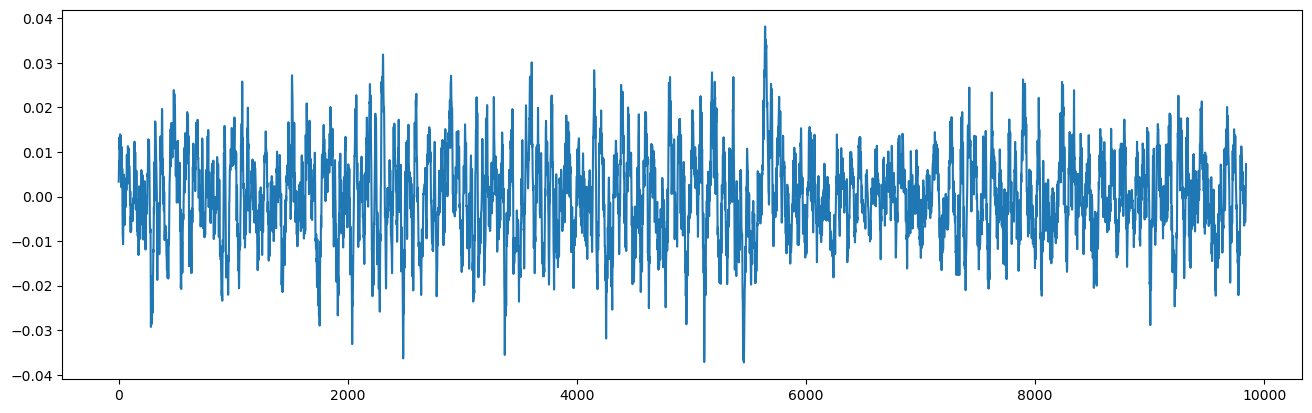

In [9]:
# view Noise
audio = get_data_whale.audio
label = get_data_noise.annotations.annotations[5]
plt.plot(audio[label.start:label.end])

In [10]:
# normalisation / feature extraction
# import utils
import librosa.util as util
audio_normalised = util.normalize(get_data_whale.audio)

In [11]:
def vis_helper(feature, title=""):
    vis.show_features(feature, title, 'y', 'x', figsize=(6, 3), cmap="viridis")

In [12]:
from spafe.features import mfcc
from spafe.utils.preprocessing import zero_handling

# create labels and data
whale_samples = []
whale_features = []
noise_features = []
for i in range(len(get_data_whale.annotations.annotations)):
    annot = get_data_whale.annotations.annotations[i]
    sample = audio_normalised[annot.start:annot.end]
    whale_samples.append(sample)
    feat, _ = mfcc.mel_spectrogram(sig=sample, fs=8000)
    features_no_zero = zero_handling(feat)
    log_features = np.log(features_no_zero)
    whale_features.append(log_features)

for i in range(len(get_data_noise.annotations.annotations)):
    annot = get_data_noise.annotations.annotations[i]
    sample = audio_normalised[annot.start:annot.end]
    feat, _ = mfcc.mel_spectrogram(sig=sample, fs=8000)
    features_no_zero = zero_handling(feat)
    log_features = np.log(features_no_zero)
    noise_features.append(log_features)

# hmm_noise.fit()

In [13]:
test = get_data_whale.annotations.annotations[0]

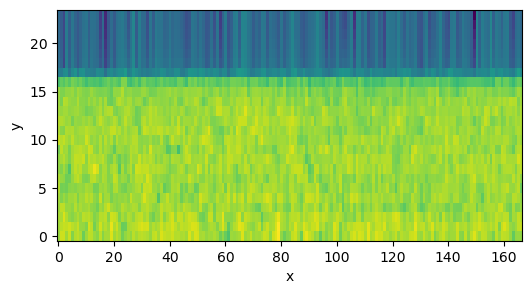

In [14]:
import spafe.utils.vis
vis_helper(noise_features[-10])

In [15]:
# train hmm noise

from hmmlearn.hmm import GaussianHMM
hmm_noise = GaussianHMM(3)
hmm_noise.fit(np.concatenate(noise_features))

hmm_whale = GaussianHMM(3)
hmm_whale.fit(np.concatenate(whale_features))

GaussianHMM(n_components=3)

In [16]:
hmm_noise.score(whale_features[5][0:200, :])

-40249.8566868254

In [17]:
hmm_whale.score(whale_features[5][0:200, :])

-7695.759626374315

In [18]:
# append and create labels

complete_data = []
complete_labels = []
for i in range(len(whale_features)):
    complete_data.append(whale_features[i])
    complete_labels.append(np.zeros(len(whale_features[i])))

for i in range(len(noise_features)):
    complete_data.append(noise_features[i])
    complete_labels.append(np.ones(len(noise_features[i])))

In [56]:
# separate using cross-validation
import final.cross_validation as cv
from final.cross_validation import *
importlib.reload(cv)

<module 'final.cross_validation' from '/Users/david/Documents/mastersCode/ubm/final/cross_validation.py'>

In [34]:
n_folds = 4
cv_output = cv.split_data_for_cross_validation(complete_data, complete_labels, n_folds)

In [41]:
from sklearn.metrics import accuracy_score
import final.models.decode_combine as dc
importlib.reload(dc)

<module 'final.models.decode_combine' from '/Users/david/Documents/mastersCode/ubm/final/models/decode_combine.py'>

In [50]:
combine_test = np.concatenate((whale_features[5], noise_features[8]), axis=0)
combined_model = dc.DecodeCombineGaussian([hmm_whale, hmm_noise])

In [51]:
states, labels, log_prob = combined_model.decode(combine_test)

calculating emission matrix
viterbi_algorithm


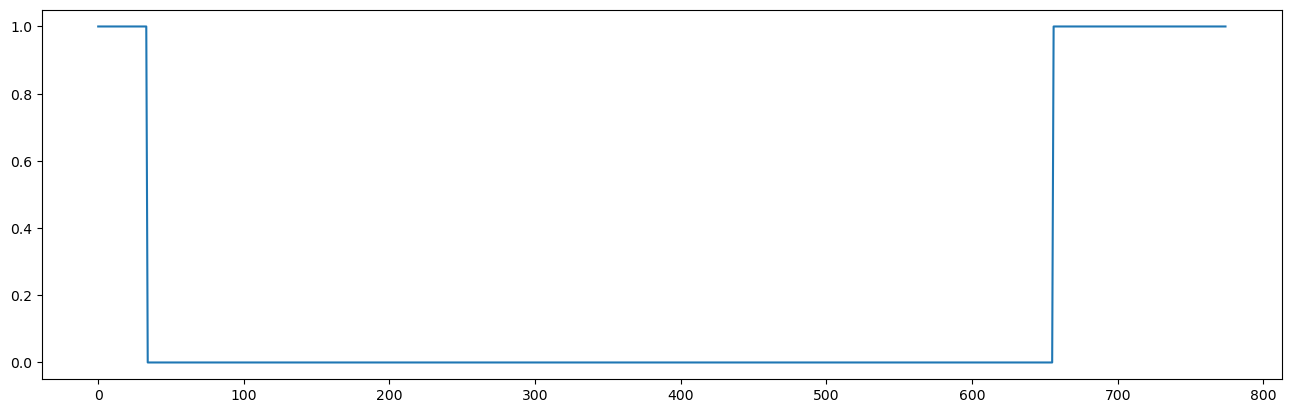

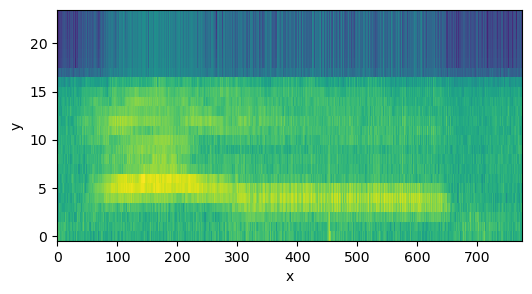

In [54]:
# plt.plot(states)
plt.plot(labels)
vis_helper(combine_test)

In [66]:
# metrics

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    return_metrics = {
        'acc': ACC,
        'tpr': TPR,
        'fpr': FPR
    }

    return return_metrics


In [67]:
import sklearn.metrics
n_comp = 4
acc = []
acc_v2 = []
for i in range(n_folds):
    n_fold_whale_hmm = GaussianHMM(n_comp)
    n_fold_whale_hmm.fit(np.concatenate(cv_output['train_data'][i]))
    combined = dc.DecodeCombineGaussian([n_fold_whale_hmm, hmm_noise])
    states, y_pred, log_prob = combined_model.decode(np.concatenate(cv_output['val_data'][i]))
    y_true = np.concatenate(cv_output['val_label'][i])
    acc.append(accuracy_score(y_true, y_pred))
    acc_v2.append(perf_measure(y_true, y_pred))

calculating emission matrix
viterbi_algorithm
calculating emission matrix
viterbi_algorithm
calculating emission matrix
viterbi_algorithm
calculating emission matrix
viterbi_algorithm


In [63]:
print(np.mean(acc))

0.8237107157103416
